In [1]:
import os
import gc
from functools import partial, wraps
from datetime import datetime as dt
import warnings
warnings.simplefilter('ignore', FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

In [2]:
TARGET = 'HasDetections'
TARGET_INDEX = 'MachineIdentifier'


def modeling_cross_validation(params, X, y, nr_folds=5):
    clfs = list()
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    kfolds = StratifiedKFold(n_splits=nr_folds, shuffle=False, random_state=42)
    for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        print("Fold {}".format(n_fold+1))
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=200, eval_metric='auc',
            early_stopping_rounds=150
        )

        clfs.append(model)
        oof_preds[val_idx] = model.predict(X_valid, num_iteration=model.best_iteration_)
        
    score = roc_auc_score(y, oof_preds)
    print(score)
    return clfs, score



In [3]:
def predict_cross_validation(test, clfs):
    sub_preds = np.zeros(test.shape[0])
    for i, model in enumerate(clfs, 1):    
        test_preds = model.predict_proba(test, num_iteration=model.best_iteration_)
        sub_preds += test_preds[:,1]

    sub_preds = sub_preds / len(clfs)
    ret = pd.Series(sub_preds, index=test.index)
    ret.index.name = test.index.name
    return ret

In [4]:
def predict_test_chunk(features, clfs, dtypes, filename='tmp.csv', chunks=100000):
    
    for i_c, df in enumerate(pd.read_csv('test.csv', 
                                         chunksize=chunks, 
                                         dtype=dtypes, 
                                         iterator=True)):
        df.set_index(TARGET_INDEX, inplace=True)
        preds_df = predict_cross_validation(df[features], clfs)
        preds_df = preds_df.to_frame(TARGET)

        if i_c == 0:
            preds_df.to_csv(filename, header=True, mode='a', index=True)
        else:
            preds_df.to_csv(filename, header=False, mode='a', index=True)
    
        del preds_df
        gc.collect()

In [10]:
# cf Theo Viel https://www.kaggle.com/theoviel/load-the-totality-of-the-data
dtypes = {
        #'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int32',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float32',
        'LocaleEnglishNameIdentifier':                          'int32',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float32',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int32',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int32',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float32',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float32',
        'HasDetections':                                        'int8'
    }
        
# Some of these might be redundant, tried to reduce overfitting (num_leaves < 2^max_depth)
model_params = {
            'device': 'cpu', 
        "objective": "binary",
        "boosting_type": "gbdt", 
        "learning_rate": 0.05,
        "max_depth": 8,
        "num_leaves": 120,
        "n_estimators": 3000,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.7,
        "bagging_freq": 5,
        "bagging_seed": 2018,
        'min_child_samples': 80, 
        'min_child_weight': 100.0, 
        'min_split_gain': 0.1, 
        'reg_alpha': 0.005, 
        'reg_lambda': 0.1, 
        'subsample_for_bin': 25000, 
        'min_data_per_group': 100, 
        'max_cat_to_onehot': 4, 
        'cat_l2': 25.0, 
        'cat_smooth': 2.0, 
        'max_cat_threshold': 32, 
        "random_state": 1,
        "silent": True,
        "metric": "auc",
    }


In [6]:
train_features = list()
train = pd.read_csv('train.csv', dtype=dtypes,nrows=2000000).set_index(TARGET_INDEX)

In [7]:
train.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,
0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,...,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,...,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,...,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,...,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,1
000014a5f00daa18e76b81417eeb99fc,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1379.0,0,7.0,0,NaN,53447.0,1.0,...,19844.0,0,0.0,0.0,0,0,0.0,0.0,1.0,1


In [8]:
train_features = [f for f in train.columns if f != TARGET]

In [11]:
# modeling
clfs, score = modeling_cross_validation(model_params, train[train_features], train[TARGET])
filename = 'subm_{:.6f}_{}_{}.csv'.format(score, 'LGBM', dt.now().strftime('%Y-%m-%d-%H-%M'))
predict_test_chunk(train_features, clfs, dtypes, filename=filename, chunks=100000)

Fold 1
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.715621
[400]	valid_0's auc: 0.718886
[600]	valid_0's auc: 0.720759
[800]	valid_0's auc: 0.721204
[1000]	valid_0's auc: 0.721433
[1200]	valid_0's auc: 0.721635
[1400]	valid_0's auc: 0.721845
[1600]	valid_0's auc: 0.721956
Early stopping, best iteration is:
[1491]	valid_0's auc: 0.722075


/home/admin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 2
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.717677
[400]	valid_0's auc: 0.721012
[600]	valid_0's auc: 0.722649
[800]	valid_0's auc: 0.723125
[1000]	valid_0's auc: 0.723384
[1200]	valid_0's auc: 0.723567
[1400]	valid_0's auc: 0.723757
[1600]	valid_0's auc: 0.723674
Early stopping, best iteration is:
[1477]	valid_0's auc: 0.723882


/home/admin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 3
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.715724
[400]	valid_0's auc: 0.719238
[600]	valid_0's auc: 0.720498
[800]	valid_0's auc: 0.721076
[1000]	valid_0's auc: 0.72139
[1200]	valid_0's auc: 0.721668
[1400]	valid_0's auc: 0.721945
[1600]	valid_0's auc: 0.721896
Early stopping, best iteration is:
[1463]	valid_0's auc: 0.722013


/home/admin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 4
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.716927
[400]	valid_0's auc: 0.7202
[600]	valid_0's auc: 0.721827
[800]	valid_0's auc: 0.722266
[1000]	valid_0's auc: 0.722619
[1200]	valid_0's auc: 0.722852
[1400]	valid_0's auc: 0.723027
[1600]	valid_0's auc: 0.723031
Early stopping, best iteration is:
[1477]	valid_0's auc: 0.723189


/home/admin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fold 5
Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.716034
[400]	valid_0's auc: 0.719669
[600]	valid_0's auc: 0.720839
[800]	valid_0's auc: 0.721636
[1000]	valid_0's auc: 0.722058
[1200]	valid_0's auc: 0.722316
[1400]	valid_0's auc: 0.722736
[1600]	valid_0's auc: 0.72266
Early stopping, best iteration is:
[1452]	valid_0's auc: 0.722782


/home/admin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6587005772632154


<Figure size 864x432 with 0 Axes>

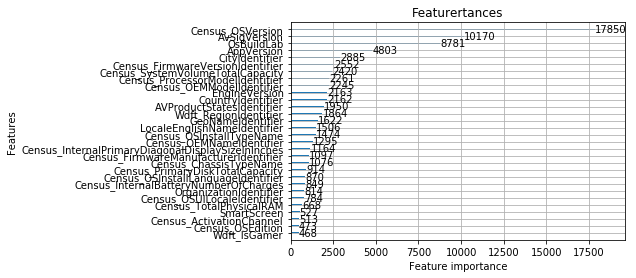

In [17]:
plt.figure(figsize=(12,6))
lgb.plot_importance(clfs[0], max_num_features=30)
plt.title("Featurertances")
plt.show()